In [1]:
import json
import re
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph
import pandas as pd
from dotenv import load_dotenv
from typing import TypedDict

# Load environment variables (GOOGLE_API_KEY should be set)
load_dotenv()

# List of bands
BAND_LIST = [
    "The Beatles", "Led Zeppelin", "Pink Floyd", "Queen", "The Rolling Stones",
    "Metallica", "Megadeth", "Black Sabbath", "Iron Maiden", "Tool", "System of a Down",
    "Radiohead", "Yes", "Genesis", "King Crimson", "Dream Theater",
    "ABBA", "Fleetwood Mac", "Coldplay", "BTS", "Imagine Dragons"
]

# Persona definitions
PERSONAS = {
    "metalhead": "You're in your 30s, a lifelong metal fan. You value power, aggression, instrumental mastery, and complexity. You dismiss pop and overproduced music as shallow.",
    "popstar": "You're in your 20s, immersed in social media culture. You love global accessibility, emotional resonance, and catchy choruses. You believe great bands bring joy and unity.",
    "boomer": "You're in your 70s. You grew up during the golden age of rock and believe greatness is rooted in legacy, songwriting, and timeless appeal. Newer music feels synthetic to you.",
    "genz": "You're a teenager, online-native, and value diversity, identity, and innovation in music. You're drawn to bands that say something real or break genre rules.",
    "indie": "You're in your 30s, an art-school type who craves authenticity, emotion, and underground cool. You dislike commercial polish and love expressive weirdness.",
    "prog": "You're a 40-something prog nerd. You value musical ambition, long-form storytelling, and unconventional structure. Simple music bores you.",
    "clueless": "You're in your 20s, not super into music theory. You just go with the vibes and what your friends like. You judge bands based on how memorable or fun they feel.",
    "data": "You're in your 50s and trust numbers over feelings. You believe greatness is measurable: sales, streams, reviews, and awards. Emotions cloud judgment."
}

# LLM config
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash-preview-05-20", temperature=0.7)

# Prompt template
def make_prompt(persona_description):
    return f"""You are a music critic with the following worldview:

{persona_description}

You have been asked to evaluate the greatness of 21 historically significant bands across genres including rock, metal, pop, and progressive.

Evaluate each band based on the following 6 criteria, scoring from 1 (low) to 3 (high):

1. Musical Innovation – Pioneering ideas, new sounds, genre blending.
2. Cultural Impact – Broader societal influence, pop culture penetration.
3. Lyrical or Thematic Depth – Narrative richness, philosophical weight, relatability.
4. Technical Proficiency – Musical complexity, virtuosity, performance execution.
5. Live Performance Strength – Energy, presence, crowd connection on stage.
6. Legacy & Longevity – Enduring influence across generations and artists.

Here are the bands to evaluate:
{chr(10).join('- ' + band for band in BAND_LIST)}

Please respond ONLY in the following strict JSON format:

{{
  "ratings": [
    {{
      "band": "Band of your choice",
      "innovation": int,
      "impact": int,
      "depth": int,
      "proficiency": int,
      "live": int,
      "legacy": int
    }},
    ...
  ],
  "justification": "Your paragraph explaining the ratings here.",
  "ranking": ["band1", "band2", ..., "band21"]
}}

- The ratings list must include all 21 bands.
- The ranking list must be in your personal order of greatness (1st to 21st).
- Do not include markdown formatting, code blocks, or commentary outside the JSON block."""

# Clean LLM output
def clean_json_string(text: str) -> str:
    cleaned = re.sub(r"```(?:json)?", "", text)
    return cleaned.replace("```", "").strip()

# Parse JSON
def parse_json_response(response):
    try:
        response_cleaned = clean_json_string(response)
        data = json.loads(response_cleaned)
        ratings = data["ratings"]
        justification = data["justification"]
        ranking = data["ranking"]
        df = pd.DataFrame(ratings)
        df.columns = ["Band", "Innovation", "Impact", "Depth", "Proficiency", "Live", "Legacy"]
        return df, justification, ranking
    except Exception as e:
        print("Error parsing JSON:", e)
        return pd.DataFrame(), "", []

# BandState
class BandState(TypedDict, total=False):
    metalhead_df: pd.DataFrame
    popstar_df: pd.DataFrame
    boomer_df: pd.DataFrame
    genz_df: pd.DataFrame
    indie_df: pd.DataFrame
    prog_df: pd.DataFrame
    clueless_df: pd.DataFrame
    data_df: pd.DataFrame
    metalhead_justification: str
    popstar_justification: str
    boomer_justification: str
    genz_justification: str
    indie_justification: str
    prog_justification: str
    clueless_justification: str
    data_justification: str
    metalhead_ranking: list[str]
    popstar_ranking: list[str]
    boomer_ranking: list[str]
    genz_ranking: list[str]
    indie_ranking: list[str]
    prog_ranking: list[str]
    clueless_ranking: list[str]
    data_ranking: list[str]
    summary_df: pd.DataFrame
    final_scores: pd.DataFrame
    winner: str

# Agent node
def make_agent_node(persona_key):
    def node(state):
        persona = PERSONAS[persona_key]
        prompt = make_prompt(persona)
        response = llm.invoke(prompt).content
        df, justification, ranking = parse_json_response(response)
        print(f"\n== {persona_key.upper()} TABLE ==")
        print(df)
        print(f"\n== {persona_key.upper()} JUSTIFICATION ==\n{justification}")
        print(f"\n== {persona_key.upper()} RANKING ==\n{ranking}")
        state[persona_key + "_df"] = df
        state[persona_key + "_justification"] = justification
        state[persona_key + "_ranking"] = ranking
        return state
    return node

# Deliberator
def deliberator_node(state):
    all_dfs = [v for k, v in state.items() if k.endswith("_df")]
    combined = pd.concat(all_dfs).groupby("Band").mean().round(2)
    state["summary_df"] = combined
    return state

# Vote
def vote_node(state):
    band_points = {band: 0 for band in BAND_LIST}
    agent_contributions = {}

    for key in PERSONAS:
        rank_list = state.get(f"{key}_ranking", [])
        agent_score = {}
        print(f"\n🎤 {key.upper()} RANKING & SCORES:")
        for i, band in enumerate(rank_list):
            if band in band_points:
                points = 21 - i  # 21 for 1st, 1 for 21st
                band_points[band] += points
                agent_score[band] = points
                print(f"{i+1:2d}. {band:25s} → {points} points")
        agent_contributions[key] = agent_score

    # Final tally
    vote_df = pd.DataFrame.from_dict(band_points, orient="index", columns=["RankScore"])
    vote_df = vote_df.sort_values("RankScore", ascending=False)

    print("\n📊 == FINAL VOTE TALLY ==")
    print(vote_df)

    state["final_scores"] = vote_df
    state["winner"] = vote_df.index[0]
    state["agent_votes"] = agent_contributions  # Optionally store for post-analysis
    return state


# Verdict
def verdict_node(state):
    print("\n🏁 Final Result Based on LLM Rank Order Voting:")
    print(state["final_scores"])
    print(f"\n🏆 Greatest Band: {state['winner']}")
    return state

# Graph build
graph = StateGraph(BandState)
for key in PERSONAS:
    graph.add_node(key, make_agent_node(key))
graph.add_node("deliberator", deliberator_node)
graph.add_node("vote", vote_node)
graph.add_node("verdict", verdict_node)

# Graph edges
agent_keys = list(PERSONAS.keys())
graph.set_entry_point(agent_keys[0])
for i in range(len(agent_keys) - 1):
    graph.add_edge(agent_keys[i], agent_keys[i + 1])
graph.add_edge(agent_keys[-1], "deliberator")
graph.add_edge("deliberator", "vote")
graph.add_edge("vote", "verdict")

# Run
compiled = graph.compile()
result = compiled.invoke({})



== METALHEAD TABLE ==
                  Band  Innovation  Impact  Depth  Proficiency  Live  Legacy
0          The Beatles           3       3      2            1     1       3
1         Led Zeppelin           3       3      2            3     3       3
2           Pink Floyd           3       3      3            2     2       3
3                Queen           2       3      2            2     3       3
4   The Rolling Stones           1       3      1            1     2       3
5            Metallica           3       3      3            3     3       3
6             Megadeth           2       2      2            3     2       2
7        Black Sabbath           3       3      3            2     2       3
8          Iron Maiden           2       3      2            2     3       3
9                 Tool           3       2      3            3     3       3
10    System of a Down           3       2      3            2     3       2
11           Radiohead           3       2      3    

In [2]:
for agent in result:
    if agent.endswith("_ranking"):
        persona = agent.replace("_ranking", "")
        ranking = result[agent]
        print(f"🎤 {persona.upper()} Top 5: {ranking[:5]}")


🎤 METALHEAD Top 5: ['Dream Theater', 'Tool', 'King Crimson', 'Metallica', 'Led Zeppelin']
🎤 POPSTAR Top 5: ['BTS', 'Queen', 'ABBA', 'Coldplay', 'Pink Floyd']
🎤 BOOMER Top 5: ['The Beatles', 'Led Zeppelin', 'Pink Floyd', 'Queen', 'The Rolling Stones']
🎤 GENZ Top 5: ['System of a Down', 'Tool', 'Pink Floyd', 'BTS', 'Radiohead']
🎤 INDIE Top 5: ['Tool', 'Radiohead', 'King Crimson', 'Pink Floyd', 'Black Sabbath']
🎤 PROG Top 5: ['King Crimson', 'Yes', 'Pink Floyd', 'Genesis', 'Dream Theater']
🎤 CLUELESS Top 5: ['Queen', 'Led Zeppelin', 'Metallica', 'BTS', 'Pink Floyd']
🎤 DATA Top 5: ['The Beatles', 'Led Zeppelin', 'Pink Floyd', 'Fleetwood Mac', 'Metallica']


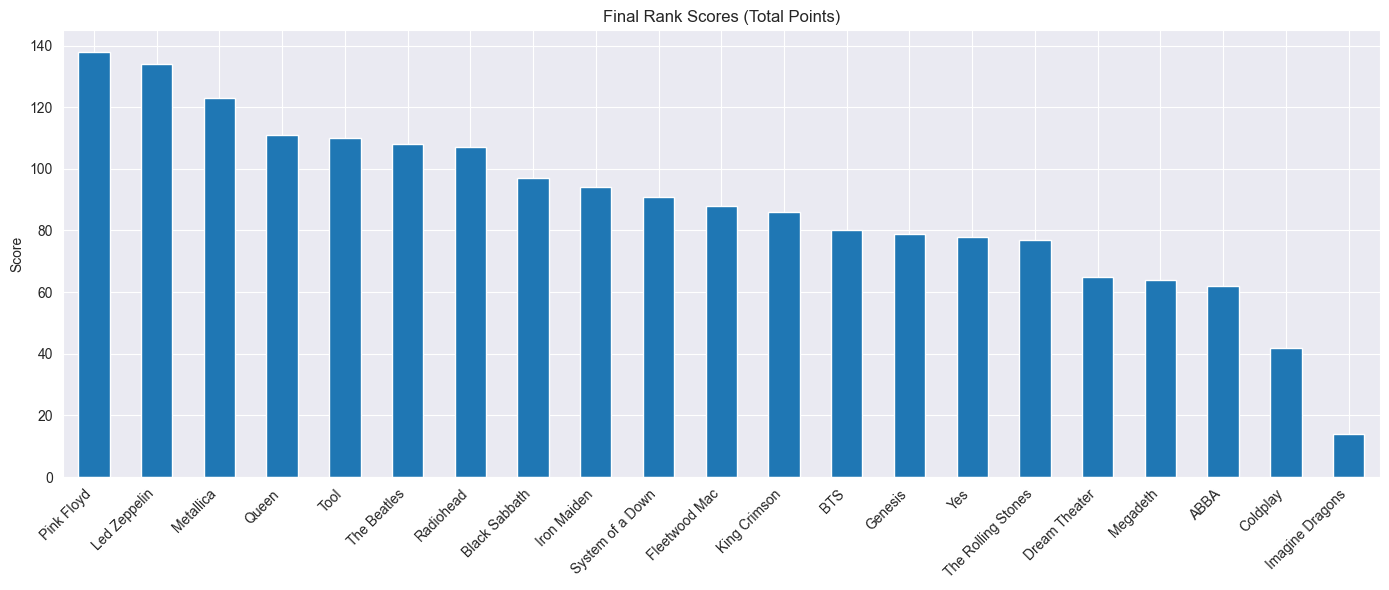

In [3]:
import matplotlib.pyplot as plt

result["final_scores"].plot(kind="bar", figsize=(14, 6), legend=False)
plt.title("Final Rank Scores (Total Points)")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


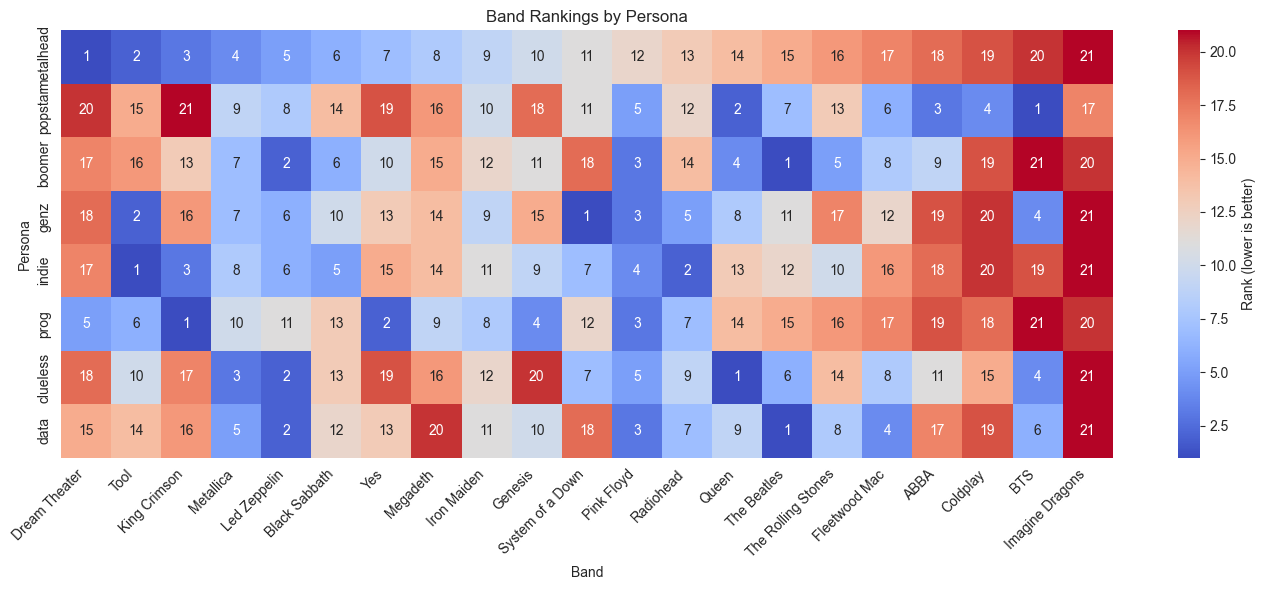

In [4]:
import pandas as pd
import seaborn as sns

# Assemble the heatmap DataFrame
rank_matrix = []
for agent in PERSONAS:
    ranking = result[f"{agent}_ranking"]
    rank_row = {band: i + 1 for i, band in enumerate(ranking)}
    rank_matrix.append(rank_row)

rank_df = pd.DataFrame(rank_matrix, index=PERSONAS.keys())
plt.figure(figsize=(14, 6))
sns.heatmap(rank_df, cmap="coolwarm", annot=True, fmt="d", cbar_kws={"label": "Rank (lower is better)"})
plt.title("Band Rankings by Persona")
plt.xlabel("Band")
plt.ylabel("Persona")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [5]:
import numpy as np

# Compute standard deviation of rankings across agents
band_ranks = {band: [] for band in BAND_LIST}
for agent in PERSONAS:
    for i, band in enumerate(result[f"{agent}_ranking"]):
        band_ranks[band].append(i + 1)

stats = {
    band: {
        "mean_rank": np.mean(ranks),
        "std_dev": np.std(ranks),
        "min_rank": min(ranks),
        "max_rank": max(ranks)
    }
    for band, ranks in band_ranks.items()
}

rank_stats_df = pd.DataFrame(stats).T.sort_values("std_dev", ascending=False)
rank_stats_df


,mean_rank,std_dev,min_rank,max_rank
BTS,12.000,8.366600,1.0,21.0
King Crimson,11.250,7.224092,1.0,21.0
Dream Theater,13.875,6.489174,1.0,20.0
Tool,8.250,5.889609,1.0,16.0
ABBA,14.250,5.539630,3.0,19.0
Yes,12.250,5.448624,2.0,19.0
System of a Down,10.625,5.360445,1.0,18.0
The Beatles,8.500,5.291503,1.0,15.0
Coldplay,16.750,5.043560,4.0,20.0
Queen,8.125,4.985918,1.0,14.0


In [6]:
df = result["summary_df"]
df.head()


,Innovation,Impact,Depth,Proficiency,Live,Legacy
Band,,,,,,
ABBA,1.62,3.00,1.25,1.62,1.00,2.75
BTS,1.88,2.75,1.75,2.00,2.25,2.00
Black Sabbath,2.88,3.00,2.12,1.88,2.00,3.00
Coldplay,1.00,2.62,1.38,1.12,2.38,1.62
Dream Theater,2.38,1.25,2.12,3.00,2.38,2.00


In [7]:
for col in df.columns:
    print(f"\n🔹 Top 5 bands by {col.upper()}:")
    display(df.sort_values(col, ascending=False).head(5))



🔹 Top 5 bands by INNOVATION:


,Innovation,Impact,Depth,Proficiency,Live,Legacy
Band,,,,,,
King Crimson,3.00,1.25,2.75,3.00,2.12,2.25
Pink Floyd,3.00,3.00,3.00,2.12,2.88,3.00
Radiohead,3.00,2.75,3.00,2.12,2.25,2.75
Genesis,2.88,2.00,2.38,2.62,2.50,2.12
Black Sabbath,2.88,3.00,2.12,1.88,2.00,3.00



🔹 Top 5 bands by IMPACT:


,Innovation,Impact,Depth,Proficiency,Live,Legacy
Band,,,,,,
ABBA,1.62,3.0,1.25,1.62,1.0,2.75
Black Sabbath,2.88,3.0,2.12,1.88,2.0,3.00
Queen,2.50,3.0,1.75,2.75,3.0,2.88
Led Zeppelin,2.88,3.0,2.12,2.88,3.0,3.00
Metallica,2.88,3.0,2.25,2.88,3.0,3.00



🔹 Top 5 bands by DEPTH:


,Innovation,Impact,Depth,Proficiency,Live,Legacy
Band,,,,,,
Radiohead,3.00,2.75,3.00,2.12,2.25,2.75
Tool,2.88,2.00,3.00,3.00,2.75,2.50
Pink Floyd,3.00,3.00,3.00,2.12,2.88,3.00
King Crimson,3.00,1.25,2.75,3.00,2.12,2.25
System of a Down,2.62,2.00,2.62,2.12,2.62,2.00



🔹 Top 5 bands by PROFICIENCY:


,Innovation,Impact,Depth,Proficiency,Live,Legacy
Band,,,,,,
Dream Theater,2.38,1.25,2.12,3.0,2.38,2.00
Tool,2.88,2.00,3.00,3.0,2.75,2.50
Yes,2.88,1.75,2.38,3.0,2.12,2.12
King Crimson,3.00,1.25,2.75,3.0,2.12,2.25
Megadeth,2.00,1.88,1.75,3.0,2.00,2.00



🔹 Top 5 bands by LIVE:


,Innovation,Impact,Depth,Proficiency,Live,Legacy
Band,,,,,,
Iron Maiden,2.00,2.38,2.12,2.75,3.00,2.88
Queen,2.50,3.00,1.75,2.75,3.00,2.88
Metallica,2.88,3.00,2.25,2.88,3.00,3.00
Led Zeppelin,2.88,3.00,2.12,2.88,3.00,3.00
Pink Floyd,3.00,3.00,3.00,2.12,2.88,3.00



🔹 Top 5 bands by LEGACY:


,Innovation,Impact,Depth,Proficiency,Live,Legacy
Band,,,,,,
Black Sabbath,2.88,3.00,2.12,1.88,2.00,3.00
Led Zeppelin,2.88,3.00,2.12,2.88,3.00,3.00
Pink Floyd,3.00,3.00,3.00,2.12,2.88,3.00
Metallica,2.88,3.00,2.25,2.88,3.00,3.00
Iron Maiden,2.00,2.38,2.12,2.75,3.00,2.88


In [9]:
df["std_dev"] = df.std(axis=1)
df["mean"] = df.mean(axis=1)
df_consistency = df.sort_values("std_dev")
df_consistency[["mean", "std_dev"]]


,mean,std_dev
Band,,
Imagine Dragons,1.093616,0.415744
Coldplay,1.541251,0.668612
BTS,1.895905,0.682015
Megadeth,1.898912,0.692778
Fleetwood Mac,2.012428,0.731298
Dream Theater,1.979092,0.744888
System of a Down,2.097062,0.753542
The Rolling Stones,2.054653,0.774298
Yes,2.141563,0.777790


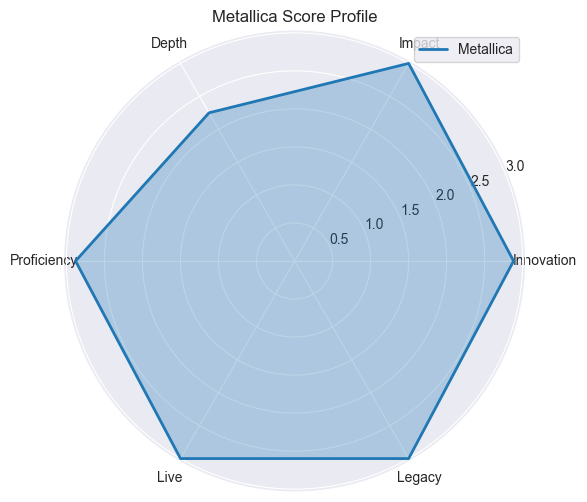

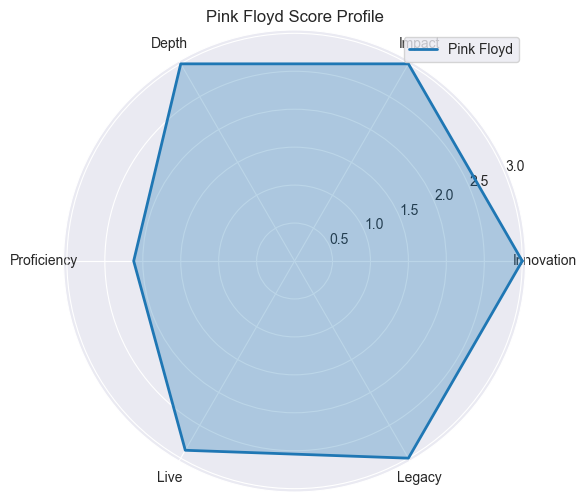

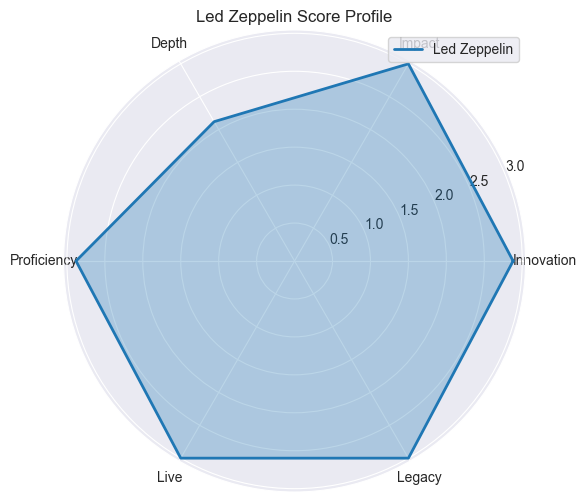

In [10]:
import matplotlib.pyplot as plt
import numpy as np

top3 = df.mean(axis=1).sort_values(ascending=False).head(3).index
categories = list(df.columns[:-2])  # exclude mean/std_dev

for band in top3:
    values = df.loc[band, categories].values.flatten().tolist()
    values += values[:1]  # repeat first value to close the radar loop

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    ax.plot(angles, values, linewidth=2, label=band)
    ax.fill(angles, values, alpha=0.3)
    ax.set_thetagrids(np.degrees(angles[:-1]), categories)
    ax.set_title(f"{band} Score Profile")
    plt.legend()
    plt.show()


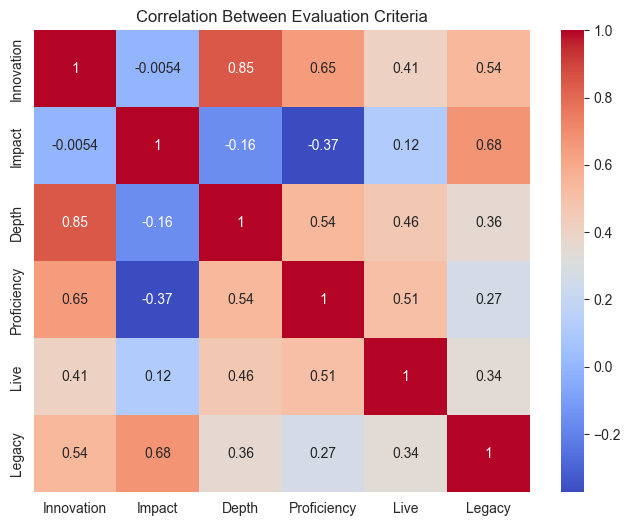

In [14]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(df[categories].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Evaluation Criteria")
plt.show()


C:\Users\EricTan\Documents\python_program\best-band\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


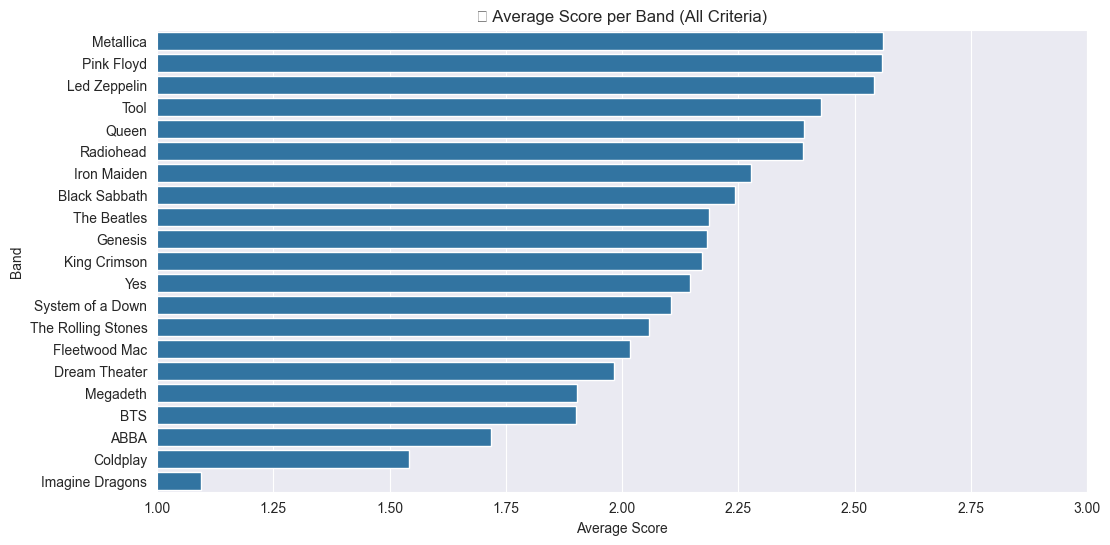

In [18]:
df["mean"] = df.mean(axis=1)
df_sorted = df.sort_values("mean", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=df_sorted["mean"], y=df_sorted.index)
plt.title("🏆 Average Score per Band (All Criteria)")
plt.xlabel("Average Score")
plt.ylabel("Band")
plt.xlim(1, 3)
plt.show()


C:\Users\EricTan\Documents\python_program\best-band\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127932 (\N{MUSICAL SCORE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


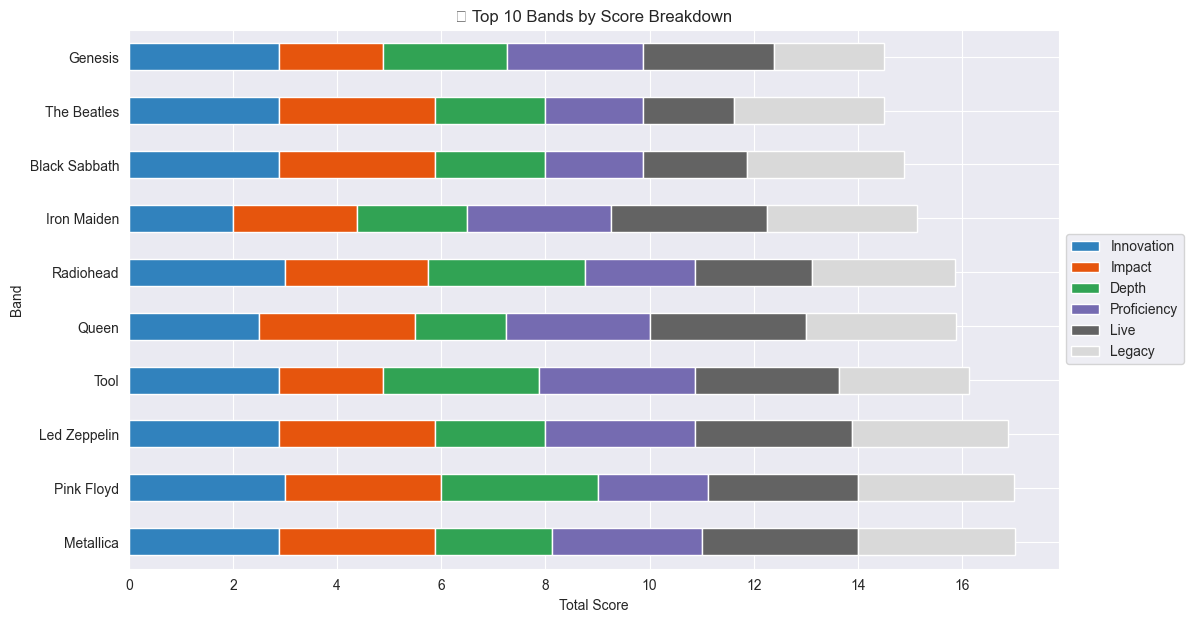

In [20]:
top_bands = df_sorted.head(10)
top_bands.iloc[:, :6].plot(kind='barh', stacked=True, figsize=(12, 7), colormap='tab20c')
plt.title("🎼 Top 10 Bands by Score Breakdown")
plt.xlabel("Total Score")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
